#### update

- 3/31
    - wav_annot_split: segment 인덱스 넘어가는 부분 수정
    - filter 추가
- 3/31 데이터셋 다시 생성
    1. normal 있는거 + size 224
    2. normal 없는거 + size 224
    3. normal 있는거 + size 1280, 720
    4. normal 없는거 + size 1280, 720

  
  

### import

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
from PIL import Image
from io import BytesIO
import io
import matplotlib.patches as patches
import gc
import cv2
# from google.colab.patches import cv2_imshow
from scipy.signal import butter, lfilter


# xml
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import ElementTree, Element, SubElement, tostring
from xml.dom import minidom

In [2]:
current_directory = os.getcwd()
print("Current directory:", current_directory)

Current directory: /home/sogaksa123/AIFFEL_THON/data/dataset6_fix_0408


In [3]:
# directory
database_dir = '/home/sogaksa123/AIFFEL_THON/ICBHI2017_Data/ICBHI_final_database/ICBHI_final_database/'

## Function

### split_audio_file, zero_padd

In [4]:
# 오디오 파일을 duration대로 잘라서 sample array 리스트로 반환
def split_audio_file(file_path, duration, sr=8000):
    # 오디오 파일 로딩
    audio, sr = librosa.load(file_path, sr=sr)
    # 분할할 샘플의 수 계산
    samples_per_segment = int(duration * sr)
    # 총 세그먼트 수 계산
    total_segments = int(np.ceil(len(audio) / samples_per_segment))
    # 세그먼트별로 오디오 분할
    segments = []
    for segment in range(total_segments):
        start_sample = samples_per_segment * segment
        end_sample = start_sample + samples_per_segment
        segments.append(audio[start_sample:end_sample])
    return segments


# 잘린 오디오 파일 sample array를 받아서 마지막 부분 padding된 리스트 반환
def zero_padd(segments, duration, sr=8000):
    segments_ls = []
    for segment in segments:
        padding_length = duration*sr - len(segment)
        if int(len(segment)/sr) < duration:
            padded_audio = np.pad(segment, (0, padding_length), mode='constant', constant_values=(0, 0))
        else:
            padded_audio = segment
        segments_ls.append(padded_audio)
    return segments_ls


### filtering_num

In [5]:
# BandPass
def butter_bandpass(lowcut, highcut,fs, order=5):
    nyq= 0.5*fs
    low= lowcut/nyq
    high= highcut/nyq
    b,a = butter(order, [low,high], btype='band')
    return b,a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b,a= butter_bandpass(lowcut, highcut, fs, order)
    y=lfilter(b,a,data)
    return y

# LowPass
def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, low, btype='low')
    return b, a

def butter_lowpass_filter(data, lowcut, fs, order=5):
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# 반복 횟수
def filtering_num(y, n, lowcut, highcut, fs, order=5, bandorlow='band'):
    '''
    data: sample
    n: 횟수
    fs: sample rate
    bandorlow 
        'band' : bandpass
        'low' : lowpass
    '''
    if n == 0: pass
    else:
        for i in range(n):
            if bandorlow == 'band':
                y = butter_bandpass_filter(y, lowcut, highcut, fs, order)
            if bandorlow == 'low':
                y = butter_lowpass_filter(y, highcut, fs, order)
    return y

In [6]:
# # test

# wav_file_path = database_dir+'158_2p3_Tc_mc_AKGC417L.wav'  # 오디오 파일 경로
# y, sr = librosa.load(wav_file_path, sr=8000)  # y는 오디오 신호, sr은 샘플링 레이트
# print('1:', y.size)

# # 원본 오디오 시각화
# plt.figure(figsize=(10, 4))
# plt.plot(y)
# plt.title('Filtered Signal')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')
# plt.show()
# #멜 스펙트로그램 생성
# mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=3000)
# mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
# # 멜 스펙트로그램 시각화
# plt.figure(figsize=(10, 4))
# librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr, fmax=3000)
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel Spectrogram (Iteration 0)')
# plt.xlabel('Time')
# plt.ylabel('Mel Frequency')
# plt.tight_layout()
# plt.show()

# # 필터링 적용 #####################################
# y = filtering_num(y, 5, 50, 2000, sr, 5, 'band')
# print(type(y)) # <class 'numpy.ndarray'>
# print('2:', y.size)
# #멜 스펙트로그램 생성
# mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=3000)
# mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# # b=np.where((mel_spec_db >= -30) & (mel_spec_db <= 0), mel_spec_db, -80)
# # 원본 오디오 시각화
# plt.figure(figsize=(10, 4))
# plt.plot(y)
# plt.title('Filtered Signal')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')
# plt.show()
# # 멜 스펙트로그램 시각화
# plt.figure(figsize=(10, 4))
# librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr, fmax=3000)
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel Spectrogram (Iteration 5)')
# plt.xlabel('Time')
# plt.ylabel('Mel Frequency')
# plt.tight_layout()
# plt.show()



### wav_annot_split
- input: 데이터베이스 경로, 파일네임, segment duration, sr 받아서
- return: padded_segments, adjusted_dfs 반환

>- padded_segments: 해당 파일 7초 sample수 + zero-padded array 리스트
>- adjusted_dfs: 해당 파일 7초로 자른 annotation df 리스트<br><br>
> : 위 두 가지 리스트 길이는 같음



In [7]:
# sample_filename = '160_1b2_Tc_mc_AKGC417L'
# # sample_filename = '157_1b1_Lr_sc_Meditron'


# wav_path = database_dir+sample_filename+'.wav'
# y, sr = librosa.load(wav_path, sr=sr)
# a = len(y)/8000 # 전체 길이
# print('전체 길이: ', a)
# print(type(a))
# txt_path = database_dir+sample_filename+'.txt'
# annot_df = pd.read_csv(txt_path, sep='\t', names=['start', 'end', 'crackle', 'wheeze'])
# print(annot_df)

# b = annot_df['end'].iloc[-1] # 마지막 샘플.
# print('마지막 샘플:', b)
# print(type(b))

# duration = 7
# c = (a-b)//duration

# padded_segments, adjusted_dfs = wav_annot_split(database_dir, sample_filename, duration=7, sr=8000)
# print(len(padded_segments))
# print(len(adjusted_dfs))
# # adjusted_dfs[2]
# for i in range(len(adjusted_dfs)):
#     print(adjusted_dfs[i])

In [8]:
# quotient2 = ((len(y)/sr) - (annot_df['end'].iloc[-1]))//duration
# print((len(y)/sr))
# print(annot_df['end'].iloc[-1])
# print(quotient2)
# padded_segments = padded_segments[:-int(quotient2)]
# print(padded_segments)

In [9]:
def wav_annot_split(database_dir, filename, duration=7, sr=8000):

    wav_path = os.path.join(database_dir, filename + '.wav')
    txt_path = os.path.join(database_dir, filename + '.txt')

    # wav 데이터 얻어와서 잘라줌, 리스트로 반환 (위에서 정의한 함수 사용)
    segments = split_audio_file(wav_path, duration=duration, sr=sr)
    padded_segments = zero_padd(segments, duration=duration, sr=sr)

    # txt 데이터 가져옴
    annot_df = pd.read_csv(txt_path, sep='\t', names=['start', 'end', 'crackle', 'wheeze'])
    
    # segment보다 긴 경우 몫 구해주기
    if annot_df['start'][0] >= duration:
        quotient = annot_df['start'][0] // duration
        # 몫으로 호흡주기 데이터 없는 부분 제외
        padded_segments = padded_segments[int(quotient):]
        # 전체 호흡 수 몫만큼 줄여주기
        annot_df['start'] = annot_df['start'] - quotient*duration
        annot_df['end'] = annot_df['end'] - quotient*duration
        # 뒷 부분의 segment에 annotation이 없는 경우 -> 이미지 제거 (3/31 추가)
        y, _ = librosa.load(wav_path, sr=sr)
        divider = duration - quotient*duration
        if divider > 0:
            if ((len(y)/sr) - (annot_df['end'].iloc[-1])) // divider >= 1.0:
                # print(annot_df['end'])
                # print(';;1')
                quotient2 = ((len(y)/sr) - (annot_df['end'].iloc[-1]))//duration
                padded_segments = padded_segments[:-int(quotient2)]

    else:
        # 뒷 부분의 segment에 annotation이 없는 경우 -> 이미지 제거 (3/31 추가)
        y, _ = librosa.load(wav_path, sr=sr)
        quotient = annot_df['start'][0] // duration
        divider = duration - quotient*duration
        if divider > 0:
            if ((len(y)/sr) - (annot_df['end'].iloc[-1])) // divider >= 1.0:
            # print(';;2')
                quotient2 = ((len(y)/sr) - (annot_df['end'].iloc[-1]))//duration
                padded_segments = padded_segments[:-int(quotient2)]

    # duration(default=7) 기준으로 행 "추가"해서 df 다시만들기
    # 세그먼트 별 마지막 인덱스 추출 및 조정(split기준점)
    i_ls = [annot_df[annot_df['start'] < duration * (n + 1)].index.max() for n in range(len(padded_segments))]
    i_ls = [x + i for i, x in enumerate(i_ls) if pd.notnull(x)]  # NaN 값 제외하고 인덱스 조정
    
    # 7초 단위로 나눠지는 포인트 수 
    split_point_num = int(annot_df['end'].iloc[-1] // duration) # 인덱스 넘어가는 부분 수정(03/31)
    # 애너테이션 데이터 수정
    for i, t in enumerate(i_ls):
        if i == split_point_num: break # 인덱스 넘어가는 부분 수정(03/31)

        end_duration = duration * (i+1)
        df1 = annot_df.iloc[:t]  # 첫 번째 부분
        df2 = annot_df.iloc[t + 1:]  # 두 번째 부분

        row_at_split = annot_df.iloc[t]
        time_offset = duration * (i + 1)

        # 새로운 행 생성
        new_rows = pd.DataFrame({
            'start': [row_at_split['start'], time_offset],
            'end': [time_offset, row_at_split['end']],
            'crackle': [row_at_split['crackle']] * 2,
            'wheeze': [row_at_split['wheeze']] * 2
        })
        annot_df = pd.concat([df1, new_rows, df2]).reset_index(drop=True)


    # 각 segment에 대한 annotation df를 저장할 리스트
    adjusted_dfs = []

    # 맨 앞 [0]이랑 맨 뒤 [-1]부분 추가 -> zip(split_points[:-1], split_points[1:]) 이부분에서 사용됨
    split_points = [0] + [index + 1 for index in i_ls][:int(split_point_num)] + [len(annot_df)]

    for i, (start, end) in enumerate(zip(split_points[:-1], split_points[1:])):
        segment_df = annot_df.iloc[start:end].copy()  # 분할된 세그먼트 복사
        adjustment = i * duration  # 각 세그먼트마다 빼줄 값 계산

        # 'start'와 'end' 컬럼 조정
        segment_df['start'] = segment_df['start'] - adjustment
        segment_df['end'] = segment_df['end'] - adjustment
        # 'normal' 컬럼 추가: 'crackle'과 'wheeze'가 모두 0일 경우 1, 아니면 0
        segment_df['normal'] = segment_df.apply(lambda r: 1 if r['crackle'] == 0 and r['wheeze'] == 0 else 0, axis=1)

        # print(segment_df)
        adjusted_dfs.append(segment_df.reset_index(drop=True, inplace=False))

    return padded_segments, adjusted_dfs


### audio2mspec

audio sample array를 받아서 img로 반환

In [10]:
def audio2mspec(array, size=(224, 224),
                sr = 8000,  # 샘플링 레이트 (or 16000)
                n_mels = 64,  # 멜 필터뱅크의 수
                n_fft = 512,  # FFT 윈도우 크기
                hop_length = 256,  # 프레임 사이의 샘플 수 : n_fft // 2
                fmax = 3000):  # 최대 주파수

    # to mel
    S = librosa.feature.melspectrogram(y=array,
                                       sr=sr,
                                       n_fft=n_fft,
                                       hop_length=hop_length,
                                       n_mels=n_mels,
                                       fmax=fmax)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # to img
    plt.figure(figsize=(size[0]/100, size[1]/100))  # 이미지 크기를 인치 단위로 설정 (224x224 픽셀이 되도록 DPI 조정 필요)
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=fmax)

    # 이미지를 PIL.Image 객체로 변환
    buf = BytesIO()
    plt.savefig(buf, format='png', dpi=100)  # DPI를 조정하여 원하는 이미지 크기를 얻을 수 있음
    buf.seek(0)
    img = Image.open(buf).convert('RGB')

    # 이미지 크기 조정
    img = img.resize(size, Image.LANCZOS)
    plt.close()  # 생성된 figure를 닫음

    return img

### get_coordinate_df
: 좌표값 포함된 df 반환

In [11]:
# df -> coordinate_df
'''
splited df를 받아서,
좌표값이 포함된 df를 반환
'''

def get_coordinate_df(df, 
                      duration=7, 
                      fmax=3000, 
                      wheeze_fmin=200, 
                      wheeze_fmax=1800, 
                      crackle_fmin=50, 
                      crackle_fmax=200, 
                      normal_fmin=50, 
                      normal_fmax=200):

    ls = []
    tmp_ls = []

    for idx2, row2 in df.iterrows():
        start = row2['start']
        end = row2['end']
        crackle = row2['crackle']
        wheeze = row2['wheeze']

        x1 = start / duration
        x2 = end / duration

        # both
        if crackle and wheeze:
            c_y1 = 1 - (crackle_fmax / fmax)
            c_y2 = 1 - (crackle_fmin / fmax)
            w_y1 = 1 - (wheeze_fmax / fmax)
            w_y2 = 1 - (wheeze_fmin / fmax)
            tmp_ls = [x1, c_y1, x2, c_y2,
                      x1, w_y1, x2, w_y2,
                      '', '', '', '']
        # only crackle
        elif crackle and not wheeze:
            c_y1 = 1 - (crackle_fmax / fmax)
            c_y2 = 1 - (crackle_fmin / fmax)
            tmp_ls = [x1, c_y1, x2, c_y2,
                      '', '', '', '',
                      '', '', '', '']

    
        # only wheeze
        elif not crackle and wheeze:
            w_y1 = 1 - (wheeze_fmax / fmax)
            w_y2 = 1 - (wheeze_fmin / fmax)
            tmp_ls = ['', '', '', '',
                      x1, w_y1, x2, w_y2,
                      '', '', '', '']
        # normal
        else:
            n_y1 = 1 - (normal_fmax / fmax)
            n_y2 = 1 - (normal_fmin / fmax)
            tmp_ls = ['', '', '', '',
                      '', '', '', '',
                      x1, n_y1, x2, n_y2]

        ls.append(tmp_ls)

    coordinate_df = pd.DataFrame(ls, columns = ['x_c1','y_c1','x_c2','y_c2','x_w1','y_w1','x_w2','y_w2','x_n1','y_n1','x_n2','y_n2'])
    concat_df = pd.concat([df, coordinate_df], axis=1)

    return concat_df


In [12]:
# sample_filename = '157_1b1_Lr_sc_Meditron'
# sample_filename = '160_1b2_Tc_mc_AKGC417L'
# sample_filename = '157_1b1_Lr_sc_Meditron'
# sample_filename = '222_1b1_Ar_sc_Meditron'
# a, adjusted_dfs = wav_annot_split(database_dir, sample_filename, duration=7, sr=8000)
# df = adjusted_dfs[0]
# concat_df = get_coordinate_df(df)
# concat_df

In [13]:
# for i in range(len(a)):
#     print(a[i])
# for i in range(len(adjusted_dfs)):
#     print(adjusted_dfs[i])

In [14]:
# y, sr = librosa.load(database_dir+'160_1b2_Tc_mc_AKGC417L.wav', sr=8000)
# t = len(y)

# print(t)
# print(t - 56000) #
# print(t - 56000 - 56000)


### bbox 시각화

In [15]:
# database_dir+'160_1b2_Tc_mc_AKGC417L.txt'
# with open(database_dir+'160_1b2_Tc_mc_AKGC417L.txt') as f:
#     contents = f.read()
#     print(contents)

In [16]:
# ## test
# # sample input
# # 158_2p3_Tc_mc_AKGC417L_2
# test_sample = '124_1b1_Ll_sc_Litt3200' # filename

# # test_sample = '221_2b1_Al_mc_LittC2SE' # filename
# # test_sample = '109_1b1_Pr_sc_Litt3200'
# # test_sample = '157_1b1_Lr_sc_Meditron'
# # test_sample = '158_2p3_Tc_mc_AKGC417L'

# i = 2  # segment idx

# # parameter
# sr = 8000  # 샘플링 레이트 (or 16000)
# n_mels = 64  # 멜 필터뱅크의 수
# n_fft = 512  # FFT 윈도우 크기
# hop_length = n_fft // 2  # 프레임 사이의 샘플 수
# fmax = 2000  # 최대 주파수
# duration = 7 # segment 길이
# size = (224, 224) # 출력 이미지 크기

# # 좌표 비율 결정(적당한 값으로 수정)
# wheeze_fmin = 50
# wheeze_fmax = 1500
# crackle_fmin = 50
# crackle_fmax = 1500
# normal_fmin = 50
# normal_fmax = 1500

# ##############################################################################
# # print(type(y)) # <class 'numpy.ndarray'>
# test_array, test_dfs = wav_annot_split(database_dir, test_sample, duration=7, sr=8000)
# concat_df = get_coordinate_df(test_dfs[i], 
#                               fmax=fmax,
#                               wheeze_fmin = wheeze_fmin,
#                               wheeze_fmax = wheeze_fmax,
#                               crackle_fmin = crackle_fmin,
#                               crackle_fmax = crackle_fmax,
#                               normal_fmin = normal_fmin,
#                               normal_fmax = normal_fmax) # index로 splited data 확인
# print('concat_df')
# print(concat_df)

# y = filtering_num(test_array[i], 5, 50, 2000, sr, 5, 'band')
# print(type(y))
# tmp_img = audio2mspec(y, fmax=fmax, size=size)

# save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset4_0331/'
# if not os.path.exists(save_path):
#     os.makedirs(save_path)
# save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset4_0331/'+'sample.png'

# tmp_img.save(save_path)
# img = Image.open(save_path)
# print(img.size)

# sample_img = Image.open(save_path)

# fig, ax = plt.subplots()
# ax.imshow(sample_img)

# c_boxes = []
# w_boxes = []
# n_boxes = []
# image_width = size[0]
# image_height = size[1]

# for idx, row in concat_df.iterrows():
#     # crackle
#     if row['crackle']:
#         x_c1 = round(row['x_c1'] * image_width)
#         y_c1 = round(row['y_c1'] * image_height)
#         w_c = round((row['x_c2'] - row['x_c1']) * image_width)
#         h_c = round((row['y_c2'] - row['y_c1']) * image_height)
#         c_boxes.append((x_c1,y_c1,w_c,h_c))

#     elif not row['crackle']:
#         c_boxes.append(())

#     # wheeze
#     if row['wheeze']:
#         x_w1 = round(row['x_w1'] * image_width)
#         y_w1 = round(row['y_w1'] * image_height)
#         w_w = round((row['x_w2'] - row['x_w1']) * image_width)
#         h_w = round((row['y_w2'] - row['y_w1']) * image_height)
#         w_boxes.append((x_w1,y_w1,w_w,h_w))

#     elif not row['wheeze']:
#         w_boxes.append(())

#     # normal
#     if row['normal']:
#         x_n1 = round(row['x_n1'] * image_width)
#         y_n1 = round(row['y_n1'] * image_height)
#         w_n = round((row['x_n2'] - row['x_n1']) * image_width)
#         h_n = round((row['y_n2'] - row['y_n1']) * image_height)
#         n_boxes.append((x_n1,y_n1,w_n,h_n))

#     elif not row['normal']:
#         n_boxes.append(())

#     print(c_boxes, w_boxes, n_boxes)
#     # ax에 박스 입력
#     for box in c_boxes:
#         try :
#             c_rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1.5, edgecolor='g', facecolor='none')
#             ax.add_patch(c_rect)
#         except Exception as e: print(e)
#             # pass
#     for box in w_boxes:
#         try:
#             b_rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1.5, edgecolor='b', facecolor='none')
#             ax.add_patch(b_rect)
#         except Exception as e: print(e)
#             # pass
#     for box in n_boxes:
#         try:
#             b_rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1.5, edgecolor='y', facecolor='none')
#             ax.add_patch(b_rect)
#         except Exception as e: print(e)
#             # pass
# plt.show()


## XML

### concat_box

In [17]:
# 데이터 하나의 좌표 딕셔너리 반환해주는 함수

def concat_box(filename, concat_df, i, size=(224, 224), duration=7, sr=8000):

    c_boxes = []
    w_boxes = []
    n_boxes = []

    for idx, row in concat_df.iterrows():
        # coordinate dataframe에서 좌표값만 불러와서 변수에 저장
        # 0~1 사이 값
        if size == None:
            # crackle
            if row['crackle']:
                x_c1 = row['x_c1']
                y_c1 = row['y_c1']
                x_c2 = row['x_c2']
                y_c2 = row['y_c2']
                c_boxes.append((x_c1,y_c1,x_c2,y_c2))
            elif not row['crackle']:
                c_boxes.append((None,None,None,None))
            # wheeze
            if row['wheeze']:
                x_w1 = row['x_w1']
                y_w1 = row['y_w1']
                x_w2 = row['x_w2']
                y_w2 = row['y_w2']
                w_boxes.append((x_w1,y_w1,x_w2,y_w2))
            elif not row['wheeze']:
                w_boxes.append((None,None,None,None))
            normal########################################################normal안쓸때 일때 주석처리#########
            if row['normal']:
                x_n1 = row['x_n1']
                y_n1 = row['y_n1']
                x_n2 = row['x_n2']
                y_n2 = row['y_n2']
                n_boxes.append((x_n1,y_n1,x_n2,y_n2))
            elif not row['normal']:
                n_boxes.append((None,None,None,None))
            ############################################################################################
        # 0~224 사이 값
        else:
            image_width = size[0]
            image_height = size[1]
            # crackle
            if row['crackle']:
                x_c1 = round(row['x_c1'] * image_width)
                y_c1 = round(row['y_c1'] * image_height)
                x_c2 = round(row['x_c2'] * image_width)
                y_c2 = round(row['y_c2'] * image_height)
                if int(x_c2) == 0 or int(x_c1) == image_width: pass
                else:
                    c_boxes.append((x_c1,y_c1,x_c2,y_c2))
            elif not row['crackle']:
                c_boxes.append((None,None,None,None))
            # wheeze
            if row['wheeze']:
                x_w1 = round(row['x_w1'] * image_width)
                y_w1 = round(row['y_w1'] * image_height)
                x_w2 = round(row['x_w2'] * image_width)
                y_w2 = round(row['y_w2'] * image_height)
                if int(x_w2) == 0 or int(x_w1) == image_width : pass
                else:
                    w_boxes.append((x_w1,y_w1,x_w2,y_w2))
            elif not row['wheeze']:
                w_boxes.append((None,None,None,None))
            # normal ########################################################normal안쓸때 주석처리#########
            if row['normal']:
                x_n1 = round(row['x_n1'] * image_width)
                y_n1 = round(row['y_n1'] * image_height)
                x_n2 = round(row['x_n2'] * image_width)
                y_n2 = round(row['y_n2'] * image_height)
                if int(x_n2) == 0 or int(x_n1) == image_width : pass
                else:
                    n_boxes.append((x_n1,y_n1,x_n2,y_n2))
            elif not row['wheeze']:
                n_boxes.append((None,None,None,None))
            ##########################################################################################
    # with normal
    concat_boxes = concat_box = {'crackles': c_boxes, 'wheezes': w_boxes, 'normal': n_boxes}
    # without normal
    #concat_boxes = concat_box = {'crackles': c_boxes, 'wheezes': w_boxes}
    

    return concat_boxes

### create_xml

In [18]:
def create_xml(image_path, concat_box, output_directory):
    '''
    image_path: 이미지 파일 명이 포함된 파일 경로
    bboxes:  concat_box = {'crackles': c_boxes, 'wheezes': w_boxes, 'normal': n_boxes}
    output_directory: xml 저장 경로
    '''
    # Parse 파일 이름 및 경로
    image_filename = os.path.basename(image_path)
    image_dirname = os.path.dirname(image_path)
    # XML 파일 경로 설정
    xml_filename = os.path.join(output_directory, os.path.splitext(image_filename)[0] + '.xml') ####
    # XML 루트 요소 생성 *
    root = Element("annotation")
    # folder 요소 추가
    folder = SubElement(root, "folder")
    folder.text = os.path.basename(image_dirname)
    # filename 요소 추가
    filename = SubElement(root, "filename")
    filename.text = image_filename  #.replace('crackle', '')
    # path 요소 추가
    path = SubElement(root, "path")
    path.text = image_path
    # source 요소 추가
    source = SubElement(root, "source")
    database = SubElement(source, "database")
    database.text = "ICBHI"
    # size 요소 추가
    size = SubElement(root, "size")
    img = cv2.imread(image_path)
    height, width, depth = img.shape
    width_elem = SubElement(size, "width")
    width_elem.text = str(width)
    height_elem = SubElement(size, "height")
    height_elem.text = str(height)
    depth_elem = SubElement(size, "depth")
    depth_elem.text = str(depth)
    # segmented 요소 추가
    segmented = SubElement(root, "segmented")
    segmented.text = "0"

    # 객체 정보 추가 **************************************************

    for label, bbox in concat_box.items():
        for b in bbox:
            if b[0] == None: continue
            else:
                # 하나의 객체 설정
                object_elem = SubElement(root, "object")
                name_elem = SubElement(object_elem, "name")
                name_elem.text = label
                pose_elem = SubElement(object_elem, "pose")
                pose_elem.text = "Unspecified"
                truncated_elem = SubElement(object_elem, "truncated")
                truncated_elem.text = "0"
                difficult_elem = SubElement(object_elem, "difficult")
                difficult_elem.text = "0"
                # bbox 정의
                bndbox_elem = SubElement(object_elem, "bndbox")

                # bbox 내용 입력
                xmin_elem = SubElement(bndbox_elem, "xmin")
                xmin_elem.text = str(b[0])
                ymin_elem = SubElement(bndbox_elem, "ymin")
                ymin_elem.text = str(b[1])
                xmax_elem = SubElement(bndbox_elem, "xmax")
                xmax_elem.text = str(b[2])
                ymax_elem = SubElement(bndbox_elem, "ymax")
                ymax_elem.text = str(b[3])

    # XML 파일 저장
    xml_str = minidom.parseString(tostring(root)).toprettyxml(indent="    ")
    with open(xml_filename, "w") as xml_file:
        xml_file.write(xml_str)


# 적용

### parameter, directory 설정
```
# baseline parameter

sr = 8000  # 샘플링 레이트 (or 16000)
n_mels = 64  # 멜 필터뱅크의 수
n_fft = 512  # FFT 윈도우 크기
hop_length = n_fft // 2  # 프레임 사이의 샘플 수
fmax = 2000  # 최대 주파수
duration = 7 # segment 길이
n_filtering = 5 # 필터링 횟수

size = (224, 224) # 출력 이미지 크기
size = (1280, 720) # 출력 이미지 크기

# # 1. 따로:
# wheeze_fmin = 200
# wheeze_fmax = 1500
# crackle_fmin = 50
# crackle_fmax = 300
# normal_fmin = 50
# normal_fmax = 300

# 2. 통일:
wheeze_fmin = 50
wheeze_fmax = 1500
crackle_fmin = 50
crackle_fmax = 1500
normal_fmin = 50
normal_fmax = 1500
```

In [19]:
# parameter
sr = 8000  # 샘플링 레이트 (or 16000)
n_mels = 64  # 멜 필터뱅크의 수(64->128)
n_fft = 512  # FFT 윈도우 크기
hop_length = n_fft // 2  # 프레임 사이의 샘플 수
fmax = 2000  # 최대 주파수
duration = 7 # segment 길이
n_filtering = 0 # 필터링 횟수

size = (224, 224) # 출력 이미지 크기
# size = (1280, 720) # 출력 이미지 크기

# BOX 크기 결정
wheeze_fmin = 50
wheeze_fmax = 1500
crackle_fmin = 50
crackle_fmax = 1500
normal_fmin = 50
normal_fmax = 1500

  # sr = 8000  # 샘플링 레이트 (or 16000)
  # n_mels = 64  # 멜 필터뱅크의 수
  # n_fft = 512  # FFT 윈도우 크기
  # hop_length = n_fft // 2  # 프레임 사이의 샘플 수
  # fmax = 2000  # 최대 주파수
  # duration = 7 # segment 길이

  # # BOX 크기 결정
  # wheeze_fmin = 300       wheeze_fmin = 50
  # wheeze_fmax = 1500      wheeze_fmax = 1500
  # crackle_fmin = 50       crackle_fmin = 50
  # crackle_fmax = 200      crackle_fmax = 1500
  # normal_fmin = 50        normal_fmin = 50
  # normal_fmax = 200       normal_fmax = 1500

# directory
database_dir = '/home/sogaksa123/AIFFEL_THON/ICBHI2017_Data/ICBHI_final_database/ICBHI_final_database/' # raw database

# n_mels ~ 64 -> 128
# n_mels=128, size=(224, 224), aug='defult', y_axis='same', filter=5
# mel_save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset6_fix_0408/data_pngxml/nmels128_224_0409/png_files/' # mel save path
# xml_save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset6_fix_0408/data_pngxml/nmels128_224_0409/xml_files/' # xml save path

# 224, filtering = 5
# n_filtering = 5 # 필터링 횟수
# size = (224, 224) # 출력 이미지 크기
# mel_save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/filtering5_224/png_files/'
# xml_save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/filtering5_224/xml_files/'

mel_save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset4_0331/with_normal_224/png_files/'
xml_save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset4_0331/with_normal_224/xml_files/'

In [15]:
# 디렉토리 생성
if not os.path.exists(mel_save_path):
    os.makedirs(mel_save_path)
if not os.path.exists(xml_save_path):
    os.makedirs(xml_save_path)

all_files = os.listdir(database_dir)
wav_files = sorted([file for file in all_files if file.endswith('.wav')])

### save img

In [22]:
# test
# sample_filename = '160_1b2_Tc_mc_AKGC417L'

# save img
for idx, filename in enumerate(wav_files):
    filename = filename.replace('.wav','')
    padded_segments, _ = wav_annot_split(database_dir, filename, duration=duration, sr=sr)

    for i, array in enumerate(padded_segments):
        save_path = mel_save_path + filename+f'_{i}.png'
        y = filtering_num(array, n_filtering, 50, 2000, sr, 5, 'band')
        img = audio2mspec(y, size=size,
                            sr=sr,
                            n_mels=n_mels,
                            n_fft=n_fft,
                            hop_length=hop_length,
                            fmax=fmax)
        # 이미지 저장
        img.save(save_path)
        
    if idx % 50 == 0:
        print('idx:', idx,'/920')
        gc.collect()

print('idx:', idx+1,'/920')
print('complete')


idx: 0 /920
idx: 50 /920
idx: 100 /920
idx: 150 /920
idx: 200 /920
idx: 250 /920
idx: 300 /920
idx: 350 /920
idx: 400 /920
idx: 450 /920
idx: 500 /920
idx: 550 /920
idx: 600 /920
idx: 650 /920
idx: 700 /920
idx: 750 /920
idx: 800 /920
idx: 850 /920
idx: 900 /920
idx: 920 /920
complete


### save xml

In [16]:
# save xml
# xml_save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/filtering5_1280/xml_files/' # xml save path
# xml_save_path = '/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/xml_file'

for idx, filename in enumerate(wav_files):
    filename = filename.replace('.wav','')
    _, adjusted_dfs = wav_annot_split(database_dir, filename, duration=duration, sr=sr)

    for i, seg_df in enumerate(adjusted_dfs):
        concat_df = get_coordinate_df(seg_df, 
                                      duration=duration, 
                                      fmax=fmax, 
                                      wheeze_fmin=wheeze_fmin, 
                                      wheeze_fmax=wheeze_fmax, 
                                      crackle_fmin=crackle_fmin, 
                                      crackle_fmax=crackle_fmax, 
                                      normal_fmin=normal_fmin, 
                                      normal_fmax=normal_fmax)
        concat_boxes = concat_box(filename, concat_df, i, size)
        # 이미지 파일의 전체 경로 설정
        filepath = os.path.join(mel_save_path, filename)+f'_{i}.png'
        # XML 파일 작성
        create_xml(filepath, concat_boxes, xml_save_path)
        
    if idx % 50 == 0:
        print('idx:', idx,'/920')
        gc.collect()

print('idx:', idx+1,'/920')
print('complete')

idx: 0 /920
idx: 50 /920
idx: 100 /920
idx: 150 /920
idx: 200 /920
idx: 250 /920
idx: 300 /920
idx: 350 /920
idx: 400 /920
idx: 450 /920
idx: 500 /920
idx: 550 /920
idx: 600 /920
idx: 650 /920
idx: 700 /920
idx: 750 /920
idx: 800 /920
idx: 850 /920
idx: 900 /920
idx: 920 /920
complete


In [24]:
# 저장된 데이터 갯수 확인
# xml_save_path = '/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/xml_file'

png_files = [f for f in os.listdir(mel_save_path) if f.endswith('.png')]
xml_files = [f for f in os.listdir(xml_save_path) if f.endswith('.xml')]

print('png: ', len(png_files))
print('xml: ', len(xml_files))

png:  2978
xml:  2978


In [34]:
# print('''
# # no filtering
# ====================
# # 1. size = 224, 224''')
# mel_save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/with_normal_224/png_files/' # mel save path
# xml_save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/with_normal_224/xml_files/' # xml save path
# png_files = [f for f in os.listdir(mel_save_path) if f.endswith('.png')]
# xml_files = [f for f in os.listdir(xml_save_path) if f.endswith('.xml')]
# print('png: ', len(png_files))
# print('xml: ', len(xml_files))
# print('''
# # 2. size = 1280, 720''')
# mel_save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/with_normal_1280/png_files/' # mel save path
# xml_save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/with_normal_1280/xml_files/' # xml save path
# png_files = [f for f in os.listdir(mel_save_path) if f.endswith('.png')]
# xml_files = [f for f in os.listdir(xml_save_path) if f.endswith('.xml')]
# print('png: ', len(png_files))
# print('xml: ', len(xml_files))
# #xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
# print('''
# # filtering
# ====================
# # 1. size = 224, 224''')
# mel_save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/filtering5_224/png_files/' # mel save path
# xml_save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/filtering5_224/xml_files/' # xml save path
# png_files = [f for f in os.listdir(mel_save_path) if f.endswith('.png')]
# xml_files = [f for f in os.listdir(xml_save_path) if f.endswith('.xml')]
# print('png: ', len(png_files))
# print('xml: ', len(xml_files))
# print('''
# # 2. size = 1280, 720''')
# mel_save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/filtering5_1280/png_files/' # mel save path
# xml_save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/filtering5_1280/xml_files/' # xml save path
# png_files = [f for f in os.listdir(mel_save_path) if f.endswith('.png')]
# xml_files = [f for f in os.listdir(xml_save_path) if f.endswith('.xml')]
# print('png: ', len(png_files))
# print('xml: ', len(xml_files))


# no filtering
# 1. size = 224, 224
png:  2978
xml:  2978

# 2. size = 1280, 720
png:  2978
xml:  2978

# filtering
# 1. size = 224, 224
png:  2978
xml:  2978

# 2. size = 1280, 720
png:  2978
xml:  2978


## 시각화

In [56]:
def draw_bboxes_from_xml(xml_file_path, image_path):
    # XML 파일 파싱
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    # 이미지 로드
    image = cv2.imread(image_path)

    # XML 내의 모든 'object' 태그에 대해 반복
    for object_tag in root.findall('object'):
            # 클래스 정보 추출
        obj_class = object_tag.find('name').text
    
        # 색상 선택
        if obj_class == 'wheezes' or obj_class == 'wheeze':
            color = (255, 0, 0)  # 파란색
        elif obj_class == 'crackles' or obj_class == 'crackle' or obj_class == 'crckles':
            color = (0, 255, 0)  # 초록색
        elif obj_class == 'normal':
            color = (0, 255, 255)  # 노란색
        else:
            color = (0, 0, 0)  # 미지정 클래스의 경우 검은색
        # bndbox 정보 추출
        bndbox = object_tag.find('bndbox')
        try :
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
        except:
            xmin, ymin, xmax, ymax = 0, 0, 0, 0
        # 이미지에 경계 상자 그리기
        else: cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 1)
    
    # 경계 상자가 그려진 이미지를 보여줌
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.show()
    # cv2_imshow(image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

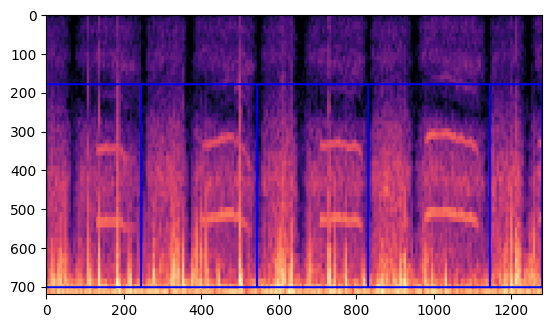

In [32]:
# 사용 예‘198_6p1_Ll_mc_AKGC417L_2.xml’221_2b1_Al_mc_LittC2SE
mel_save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/with_normal_1280/png_files/' # mel save path
xml_save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/with_normal_1280/xml_files/' # mel save path


sample_filename = '158_2p3_Tc_mc_AKGC417L_1' # 표현좋은데이터
# sample_filename = '198_6p1_Ll_mc_AKGC417L_2'
# sample_filename = '203_1p2_Al_mc_AKGC417L_2'

# sample_filename = '221_2b1_Al_mc_LittC2SE_0' # 호흡 어노테이션 끝과 전체 오디오 길이가 같은 경우
# sample_filename = '160_1b2_Tc_mc_AKGC417L_1' # 호흡 end 어노테이션 이후 segment duration보다 길어서 뒷부분 segment의 라벨이 없던 경우 
# sample_filename = '157_1b1_Lr_sc_Meditron_5' # 어노테이션 시작이 너무 늦은 경우 (31.77초)
# sample_filename = '195_1b1_Lr_sc_Litt3200_2' # 
##################################################################################

xml_file_path = xml_save_path+sample_filename+'.xml'
image_path = mel_save_path+sample_filename+'.png'
draw_bboxes_from_xml(xml_file_path, image_path)

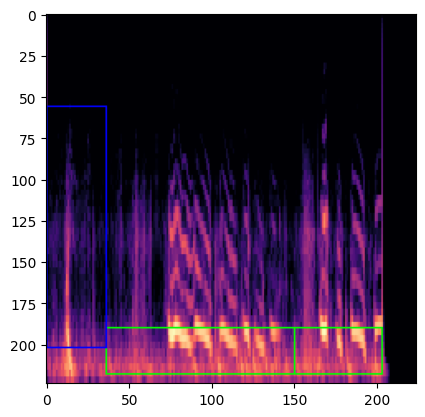

In [62]:

# filtering
# #1. size = 224, 224
mel_save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/filtering5_224/png_files/' # mel save path
xml_save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset4_0331/data_diffax_xml/xml_files/' # xml save path

# 사용 예‘198_6p1_Ll_mc_AKGC417L_2.xml’221_2b1_Al_mc_LittC2SE
# sample_filename = '124_1b1_Ll_sc_Litt3200_2'
# sample_filename = '158_2p3_Tc_mc_AKGC417L_2' # 표현좋은데이터
# sample_filename = '198_6p1_Ll_mc_AKGC417L_2'
# sample_filename = '203_1p2_Al_mc_AKGC417L_2'

# sample_filename = '221_2b1_Al_mc_LittC2SE_1' # 호흡 어노테이션 끝과 전체 오디오 길이가 같은 경우
# sample_filename = '160_1b2_Tc_mc_AKGC417L_1' # 호흡 end 어노테이션 이후 segment duration보다 길어서 뒷부분 segment의 라벨이 없던 경우 
# sample_filename = '157_1b1_Lr_sc_Meditron_5' # 어노테이션 시작이 너무 늦은 경우 (31.77초)
sample_filename = '195_1b1_Lr_sc_Litt3200_2' # 
##################################################################################

xml_file_path = xml_save_path+sample_filename+'.xml'
image_path = mel_save_path+sample_filename+'.png'
draw_bboxes_from_xml(xml_file_path, image_path)

In [33]:
# 위 이미지 xml 파일 확인
# xml_dir = '/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/xml_file/124_1b1_Ll_sc_Litt3200_2.xml'
# xml_save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset4_0331/with_normal_224/xml_files/124_1b1_Ll_sc_Litt3200_2.xml' # xml save path
# xml_save_path = '/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/xml_file/124_1b1_Ll_sc_Litt3200_2.xml'

# zeromax = '159_1b1_Ar_sc_Meditron_1.xml'
# zeromax = '124_1b1_Ll_sc_Litt3200_2.xml'
# zeromax = '159_1b1_Al_sc_Meditron_2.xml'
# zeromax = '147_1b4_Tc_mc_AKGC417L_1.xml'
# zeromax = '211_1p2_Ar_mc_AKGC417L_2.xml'
# zeromax = '157_1b1_Ar_sc_Meditron_2.xml'

# zeromax = '135_2b3_Pl_mc_LittC2SE_0.xml'

# xml_save_path = f'/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/xml_file/{zeromax}'
# xml_save_path = f'/home/sogaksa123/AIFFEL_THON/data/dataset4_0331/with_normal_224/xml_files/{zeromax}'
xml_dir = xml_save_path+sample_filename+'.xml'

with open(xml_dir) as f:
    contents = f.read()
    print(contents)

<?xml version="1.0" ?>
<annotation>
    <folder>png_files</folder>
    <filename>158_2p3_Tc_mc_AKGC417L_1.png</filename>
    <path>/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/with_normal_1280/png_files/158_2p3_Tc_mc_AKGC417L_1.png</path>
    <source>
        <database>ICBHI</database>
    </source>
    <size>
        <width>1280</width>
        <height>720</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>crckles</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>245</xmin>
            <ymin>180</ymin>
            <xmax>544</xmax>
            <ymax>702</ymax>
        </bndbox>
    </object>
    <object>
        <name>wheezes</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>0</xmin>
            <ymin>180</ymin>
            <xmax>245</xmax>
            <

In [72]:
import re

# 원본 annotation 확인

_,b = wav_annot_split(database_dir, re.sub(r'_[0-9]+$', '', sample_filename), duration=7, sr=8000)
for i, x in enumerate(b):
    print('idx: ',i, '\n', x, '\n')

txt_file = re.sub(r'_[0-9]+$', '.txt', database_dir+sample_filename)
df = pd.read_csv(txt_file, sep='\t', names=['start', 'end', 'crackle', 'wheeze'])
df

idx:  0 
    start    end  crackle  wheeze  normal
0  0.093  1.868      0.0     0.0       1
1  1.868  5.216      1.0     0.0       0
2  5.216  7.000      0.0     0.0       1 

idx:  1 
    start    end  crackle  wheeze  normal
0  0.000  0.887      0.0     0.0       1
1  0.887  3.423      0.0     0.0       1
2  3.423  6.432      0.0     0.0       1
3  6.432  7.000      0.0     0.0       1 

idx:  2 
    start    end  crackle  wheeze  normal
0  0.000  2.729      0.0     0.0       1
1  2.729  5.924      0.0     0.0       1 



,start,end,crackle,wheeze
0,0.093,1.868,0,0
1,1.868,5.216,1,0
2,5.216,7.887,0,0
3,7.887,10.423,0,0
4,10.423,13.432,0,0
5,13.432,16.729,0,0
6,16.729,19.924,0,0


In [48]:
# sample = sample_filename[:-2]
# i = sample_filename[-1]

# df = b[int(i)]
# concat_df = get_coordinate_df(df)
# boxes = concat_box(sample, concat_df, i, pix_size=224, duration=7, sr=8000)
# boxes

{'crckles': [(None, None, None, None), (100, 220, 224, 209)],
 'wheezes': [(0, 209, 100, 134), (100, 209, 224, 134)],
 'normal': []}

In [73]:
# create_xml('/content/drive/MyDrive/aiffel/AIFFELthon/1_data/data3/'+sample_filename+'.png',
#            boxes,
#            '/content/drive/MyDrive/aiffel/AIFFELthon/experiment/')

# with open('/content/drive/MyDrive/aiffel/AIFFELthon/experiment/'+sample_filename+'.xml') as f:
#     contents = f.read()
#     print(contents)

<?xml version="1.0" ?>
<annotation>
    <folder>data3</folder>
    <filename>198_6p1_Ll_mc_AKGC417L_2.png</filename>
    <path>/content/drive/MyDrive/aiffel/AIFFELthon/1_data/data3/198_6p1_Ll_mc_AKGC417L_2.png</path>
    <source>
        <database>ICBHI</database>
    </source>
    <size>
        <width>224</width>
        <height>224</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>crckles</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>100</xmin>
            <ymin>220</ymin>
            <xmax>224</xmax>
            <ymax>209</ymax>
        </bndbox>
    </object>
    <object>
        <name>wheezes</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>0</xmin>
            <ymin>209</ymin>
            <xmax>100</xmax>
            <ymax>134</ymax>
        </

In [ ]:
'''
159_1b1_Ar_sc_Meditron_1.png
124_1b1_Ll_sc_Litt3200_2.png
159_1b1_Al_sc_Meditron_2.png
147_1b4_Tc_mc_AKGC417L_1.png
211_1p2_Ar_mc_AKGC417L_2.png
135_2b3_Ar_mc_LittC2SE_1.png
157_1b1_Ar_sc_Meditron_2.png
'''